# RFM Clustering
# 20233219 Taewoo Kim

## Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
pd.set_option('mode.chained_assignment',  None) #경고 끄기
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) #경고끄기

In [2]:
df = pd.read_csv('online_retail_II.csv')

In [3]:
#불필요한 column 제거
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
#Revenue 변수 생성
df['Revenue'] = df['Quantity']*df['Price']

In [5]:
#'Customer ID' 결측치는 새로운 데이터프레임에 저장, 기존 데이터프레임에서는 삭제
df_noID = df[df['Customer ID'].isna()]
df.dropna(subset=['Customer ID'], inplace = True)
#'Description' 결측치는 채워줌
df['Description'].fillna('No Description', inplace = True)
#음수 제거
df = df[df['Quantity'] > 0]
df = df[df['Price'] >= 0]

In [6]:
#주문취소에 대한 처리
filter = df['Invoice'].str.contains('C')
#새로운 데이터프레임에 주문취소 정보 저장
df_cancel = df[filter]
#기존 데이터프레임에서 주문취소 정보 삭제 후 cl_df로 저장
cl_df = df[~df['Invoice'].str.contains('C')]

In [7]:
#데이터타입 변환
cl_df['Invoice'] = cl_df['Invoice'].astype('category')
cl_df['StockCode'] = cl_df['StockCode'].astype('category')
cl_df['Description'] = cl_df['Description'].astype('category')
cl_df['Customer ID'] = cl_df['Customer ID'].astype('object')
cl_df['InvoiceDate'] = pd.to_datetime(cl_df['InvoiceDate'])
cl_df['Country'] = cl_df['Country'].astype('category')

In [8]:
#날짜 출력 format 변경
cl_df['InvoiceDate'] = cl_df['InvoiceDate'].dt.strftime("%Y-%m-%d")
cl_df['InvoiceDate'] = pd.to_datetime(cl_df['InvoiceDate'])

In [9]:
cl_df['Quantity'] = cl_df['Quantity'].astype('int32')
cl_df['Price'] = cl_df['Price'].astype('int32')
cl_df['Revenue'] = cl_df['Revenue'].astype('float32')

In [10]:
cl_df.shape

(805620, 9)

In [11]:
#중복값 제거
cl_df = cl_df.drop_duplicates()
cl_df.shape

(779493, 9)

In [12]:
print(cl_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779493 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779493 non-null  category      
 1   StockCode    779493 non-null  category      
 2   Description  779493 non-null  category      
 3   Quantity     779493 non-null  int32         
 4   InvoiceDate  779493 non-null  datetime64[ns]
 5   Price        779493 non-null  int32         
 6   Customer ID  779493 non-null  object        
 7   Country      779493 non-null  category      
 8   Revenue      779493 non-null  float32       
dtypes: category(4), datetime64[ns](1), float32(1), int32(2), object(1)
memory usage: 35.1+ MB
None


## RFM Analysis

In [13]:
latest_date = cl_df['InvoiceDate'].max()
rfm = cl_df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (latest_date - InvoiceDate.max()).days,
                                        'Invoice': lambda Invoice: Invoice.nunique(),
                                        'Revenue': lambda Revenue: Revenue.sum()})
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm['monetary'] > 0]

# RFM 각각 3등급으로 나누기
rfm['R_rank'] = pd.qcut(rfm['recency'], q=3, labels=['3', '2', '1']) # recency의 수치가 낮을수록 높은 집단
rfm['F_rank'] = pd.qcut(rfm['frequency'].rank(method='first'), q=3, labels=['1', '2', '3']) #그룹에서 표시되는 순서대로 순위 부여
rfm['M_rank'] = pd.qcut(rfm['monetary'], q=3, labels=['1', '2', '3']) 

#데이터타입 변환
rfm['R_rank'] = rfm['R_rank'].astype(int)
rfm['F_rank'] = rfm['F_rank'].astype(int)
rfm['M_rank'] = rfm['M_rank'].astype(int)
# R, F, M 값을 이용해 27개 그룹 생성
rfm['RFM_Group'] = rfm['R_rank']*100 + rfm['F_rank']*10 + rfm['M_rank']
rfm['score'] = rfm['R_rank'] + rfm['F_rank'] + rfm['M_rank']

In [14]:
rfm.describe()

,recency,frequency,monetary,R_rank,F_rank,M_rank,RFM_Group,score
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,200.866791,6.289895,2955.898682,2.002042,1.999830,1.999830,222.202280,6.001701
std,209.353961,13.015651,14440.852539,0.817535,0.816601,0.816601,86.463852,2.068587
min,0.000000,1.000000,2.950000,1.000000,1.000000,1.000000,111.000000,3.000000
25%,25.000000,1.000000,342.279984,1.000000,1.000000,1.000000,122.000000,4.000000
50%,95.000000,3.000000,867.740112,2.000000,2.000000,2.000000,222.000000,6.000000
75%,379.000000,7.000000,2248.304932,3.000000,3.000000,3.000000,322.000000,8.000000
max,738.000000,398.000000,580987.062500,3.000000,3.000000,3.000000,333.000000,9.000000


In [15]:
rfm['RFM_Group'].nunique()

27

In [16]:
#score에 따라 3개의 그룹으로 분류
def rfm_level(score):
    if ((score>=3) and (score<=4)):
        return 'Inactive'
    elif ((score>=5) and (score<=7)):
        return 'Average'
    else:
        return 'Active'
    
rfm['level'] = rfm['score'].apply(lambda score: rfm_level(score))
rfm.head()

,recency,frequency,monetary,R_rank,F_rank,M_rank,RFM_Group,score,level
Customer ID,,,,,,,,,
12346.0,325,12,77556.460938,1,3,3,133,7,Average
12347.0,2,8,4921.529785,3,3,3,333,9,Active
12348.0,75,5,2019.400024,2,2,3,223,7,Average
12349.0,18,4,4428.690430,3,2,3,323,8,Active
12350.0,310,1,334.399994,1,1,1,111,3,Inactive


<Axes: xlabel='level', ylabel='count'>

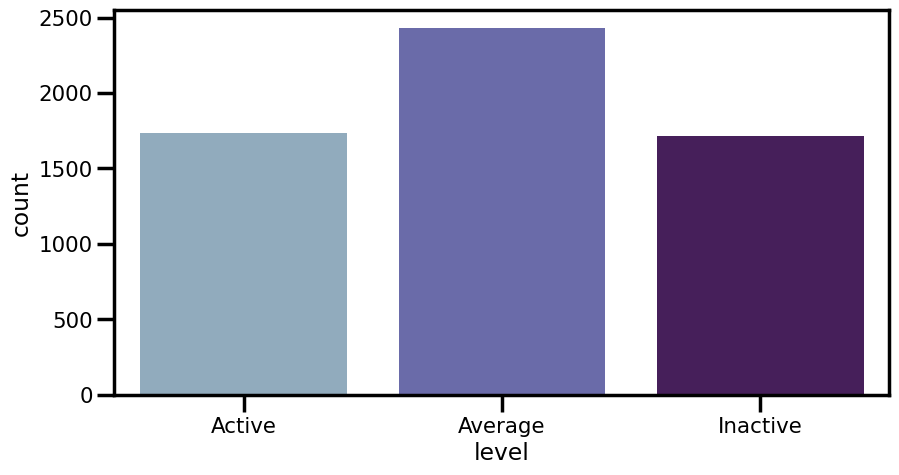

In [17]:
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(x='level', data=rfm, order=['Active', 'Average', 'Inactive'])

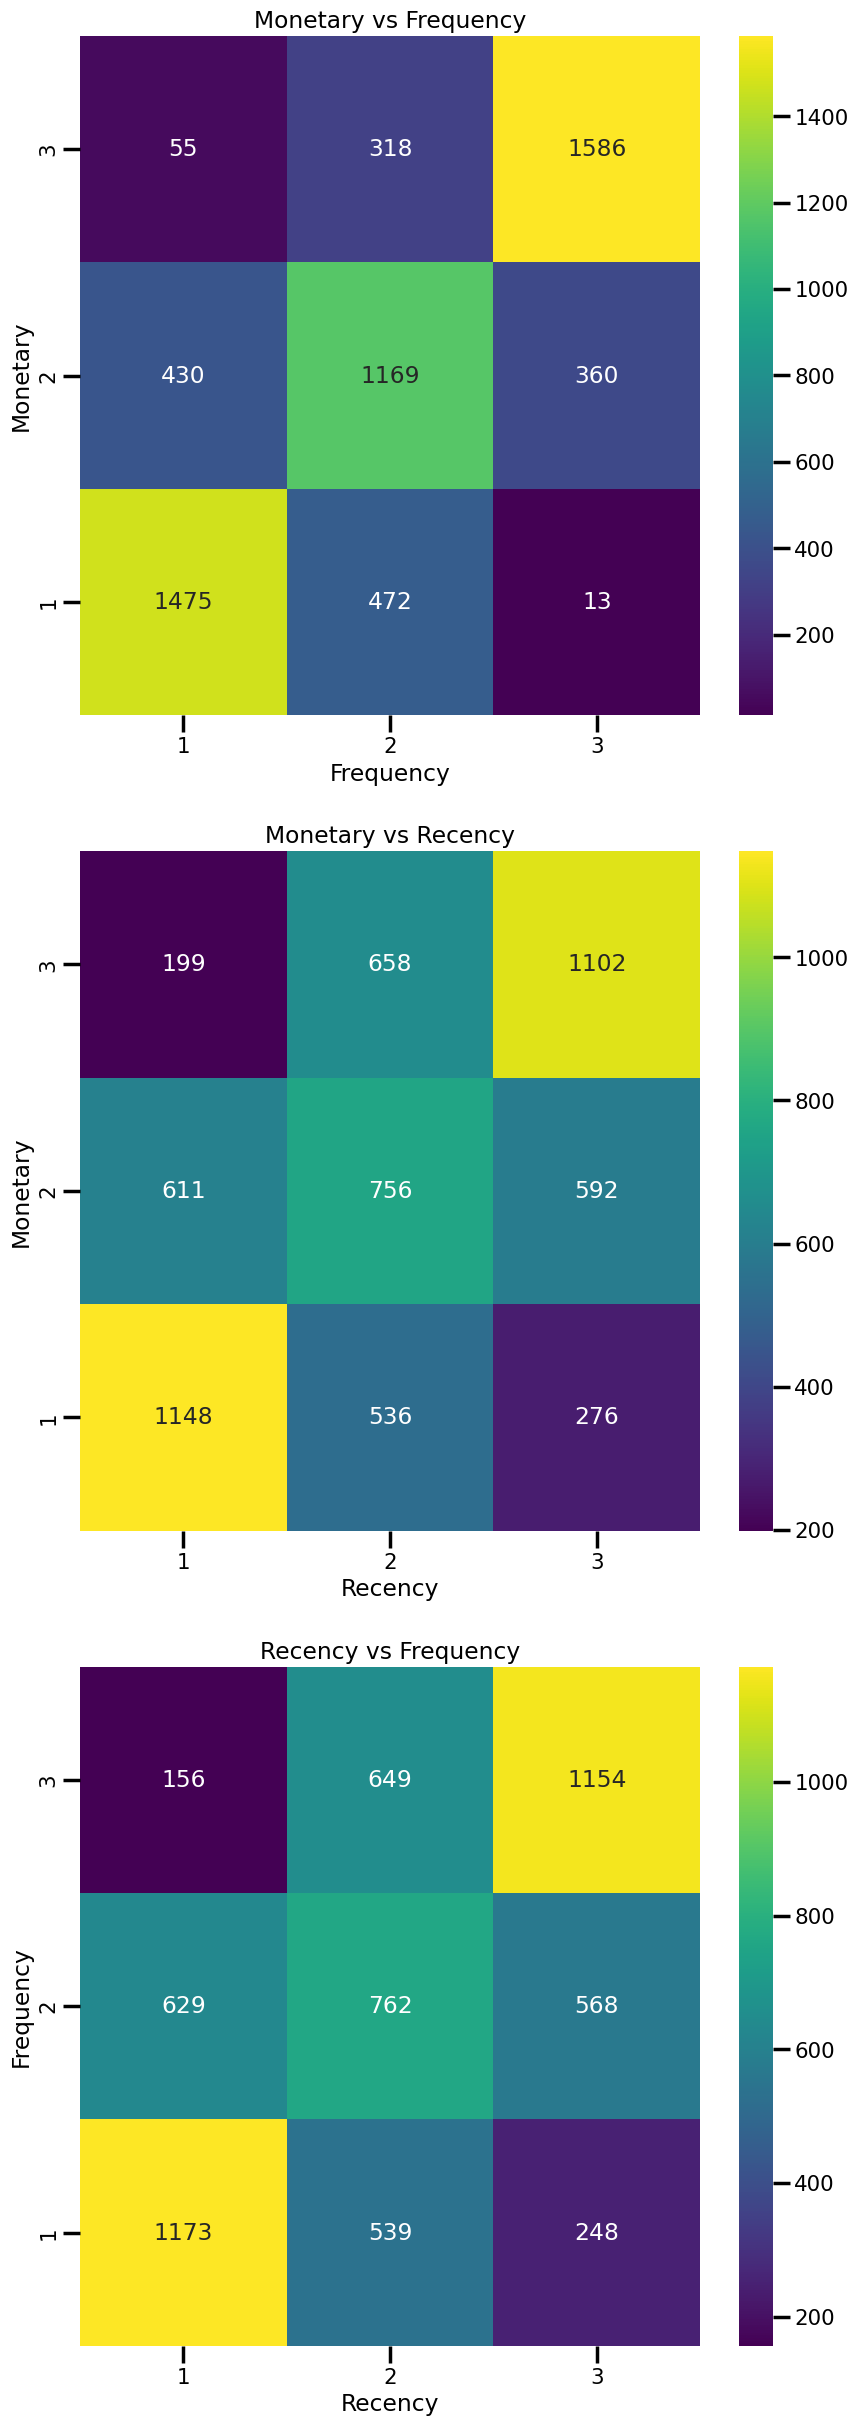

In [18]:
cross_table1 = pd.crosstab(index=rfm['M_rank'], columns=rfm['F_rank'])
cross_table2 = pd.crosstab(index=rfm['M_rank'], columns=rfm['R_rank'])
cross_table3 = pd.crosstab(index=rfm['F_rank'], columns=rfm['R_rank'])
plt.figure(figsize=(10,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

## RFM K-means Clustering

In [19]:
rfm = rfm.drop(['R_rank', 'F_rank', 'M_rank'], axis=1)

In [20]:
rfm.describe() #negative 값 확인

,recency,frequency,monetary,RFM_Group,score
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,200.866791,6.289895,2955.898682,222.202280,6.001701
std,209.353961,13.015651,14440.852539,86.463852,2.068587
min,0.000000,1.000000,2.950000,111.000000,3.000000
25%,25.000000,1.000000,342.279984,122.000000,4.000000
50%,95.000000,3.000000,867.740112,222.000000,6.000000
75%,379.000000,7.000000,2248.304932,322.000000,8.000000
max,738.000000,398.000000,580987.062500,333.000000,9.000000


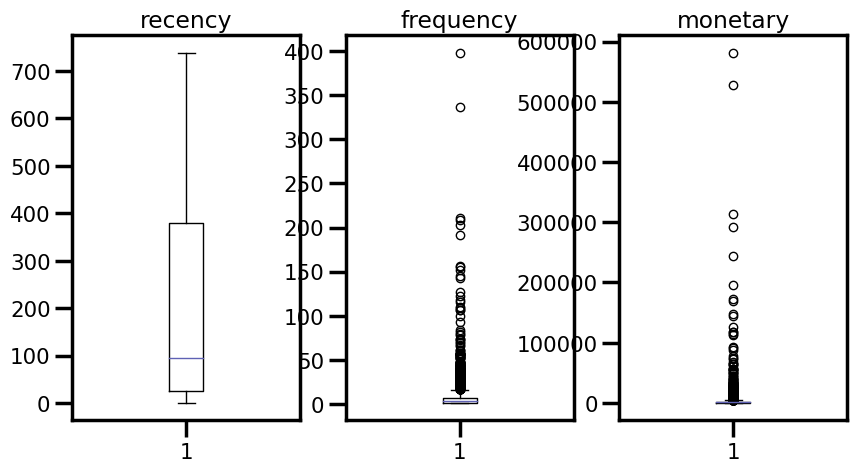

In [21]:
#boxplot으로 outlier 유무 확인
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes[0].boxplot(rfm.recency)
axes[0].set_title('recency')
axes[1].boxplot(rfm.frequency)
axes[1].set_title('frequency')
axes[2].boxplot(rfm.monetary)
axes[2].set_title('monetary')
plt.show()

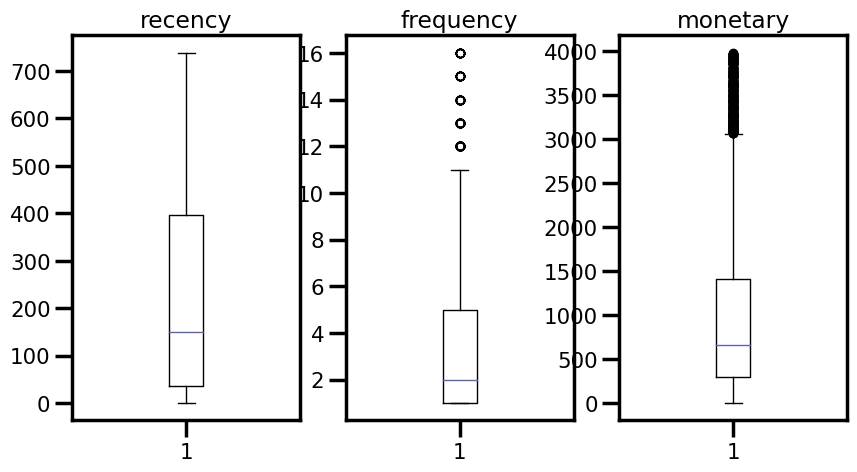

In [22]:
#outlier 제거
f_Q1 = rfm.frequency.quantile(0.25)
f_Q3 = rfm.frequency.quantile(0.75)
f_IQR = f_Q3 - f_Q1
rfm = rfm[(rfm.frequency >= f_Q1 - 1.5*f_IQR) & (rfm.frequency <= f_Q3 + 1.5*f_IQR)]

m_Q1 = rfm.monetary.quantile(0.25)
m_Q3 = rfm.monetary.quantile(0.75)
m_IQR = m_Q3 - m_Q1
rfm = rfm[(rfm.monetary >= m_Q1 - 1.5*m_IQR) & (rfm.monetary <= m_Q3 + 1.5*m_IQR)]
#재확인
#boxplot으로 outlier 유무 확인
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes[0].boxplot(rfm.recency)
axes[0].set_title('recency')
axes[1].boxplot(rfm.frequency)
axes[1].set_title('frequency')
axes[2].boxplot(rfm.monetary)
axes[2].set_title('monetary')
plt.show()

In [23]:
#변수 스케일을 조정하여 정규화
from sklearn.preprocessing import StandardScaler
k_rfm = rfm[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(k_rfm)
rfm_scaled

array([[-0.70955123,  0.51337011,  1.10722058],
       [ 0.39490445, -0.83556667, -0.7147926 ],
       [ 0.70039219, -0.83556667, -0.75098416],
       ...,
       [ 0.96358163, -0.83556667, -0.57716302],
       [ 2.03983844, -0.83556667, -0.614663  ],
       [ 1.17507314, -0.49833248,  0.3254633 ]])

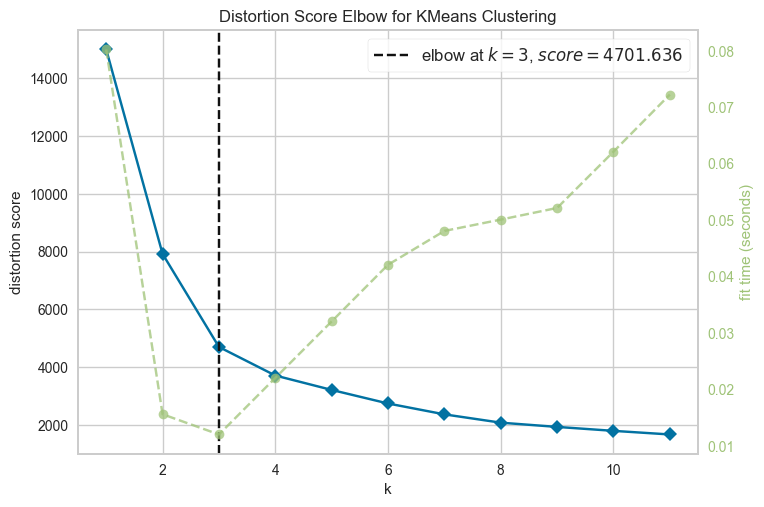

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
#Elbow-method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(rfm_scaled)
visualizer.show()

,recency,frequency,monetary
cluster_pred,,,
0,1069,1069,1069
1,1764,1764,1764
2,2168,2168,2168


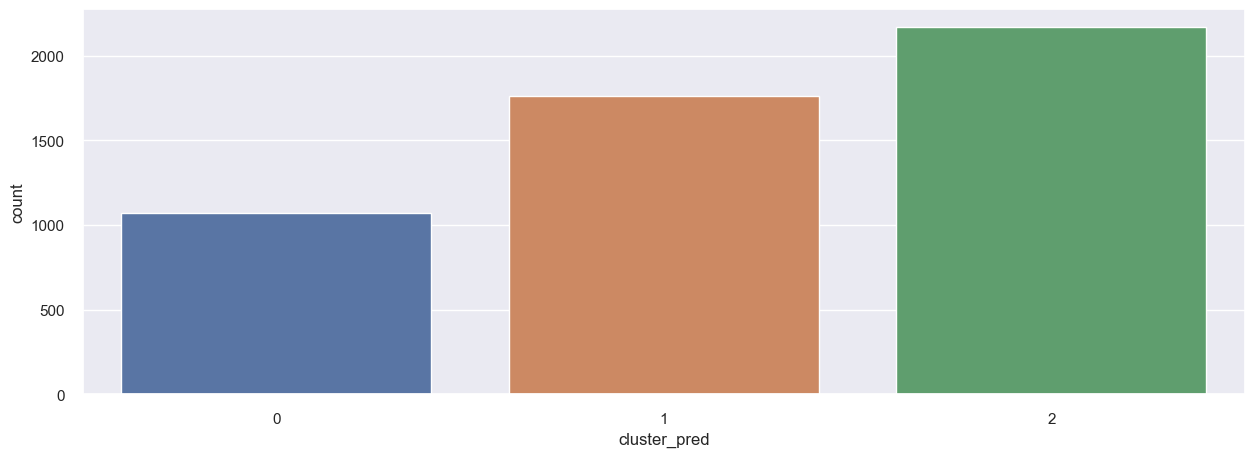

In [26]:
#apply k-means (k=3)
kmeans_scaled = KMeans(n_clusters=3, random_state=42)
kmeans_scaled.fit(rfm_scaled)

clusters_scaled = k_rfm.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(rfm_scaled)

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

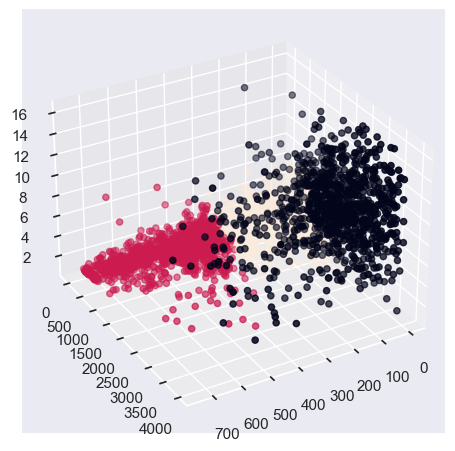

In [27]:
#visualizing the clusters
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['recency']
yline=clusters_scaled['frequency']
zline=clusters_scaled['monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

Silhouette Score: 0.439


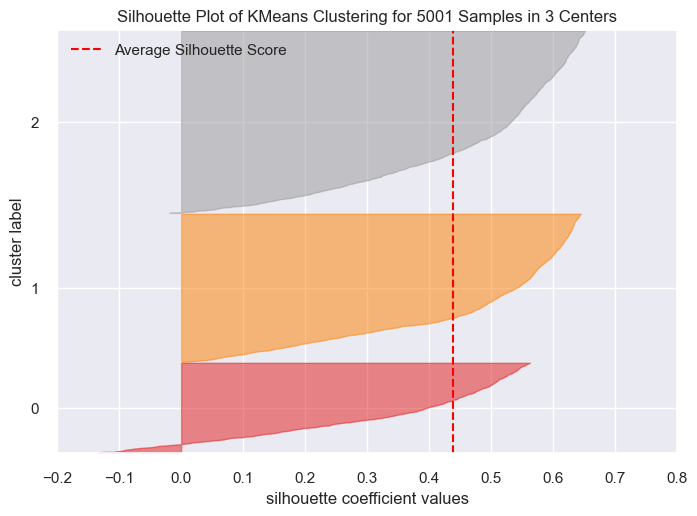

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 5001 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
#validation
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(rfm_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(rfm_scaled)   
visualizer.poof() 

In [32]:
k_rfm['cluster']= clusters_scaled['cluster_pred']
k_rfm['level']=rfm['level']

k_rfm.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

recency           frequency             monetary              \
               mean  min  max      mean min max         mean         min   
cluster                                                                    
0         87.102900    0  634  7.930776   1  16  2433.949951  167.419998   
1        476.843537  252  738  1.753401   1   9   476.827820    2.950000   
2         90.328875    0  336  2.684963   1   8   708.110779    6.200000   

                            
                 max count  
cluster                     
0        3974.749756  1069  
1        3084.020020  1764  
2        2626.300049  2168

In [33]:
k_rfm.head()

,recency,frequency,monetary,cluster,level
Customer ID,,,,,
12348.0,75,5,2019.400024,0,Average
12350.0,310,1,334.399994,1,Inactive
12351.0,375,1,300.929993,1,Inactive
12352.0,36,10,2849.839600,0,Active
12353.0,204,2,406.759979,2,Inactive


In [35]:
#transforming and storing the RFM values for plotting a snake plot
rfm_scaled = k_rfm.copy()
scaler = StandardScaler()
rfm_scaled[['recency', 'frequency', 'monetary']] = scaler.fit_transform(rfm_scaled[['recency', 'frequency', 'monetary']])
rfm_scaled['customerID'] = k_rfm.index

In [43]:
print(rfm_scaled.shape)

(5001, 6)


In [44]:
#melting the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customerID', 'level', 'cluster'], var_name = 'metrics', value_name = 'value')
print(rfm_melted.shape)

(15003, 5)


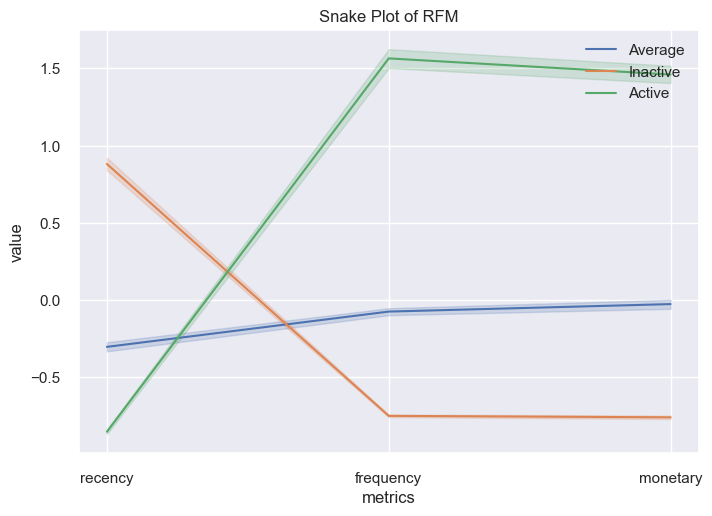

In [45]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

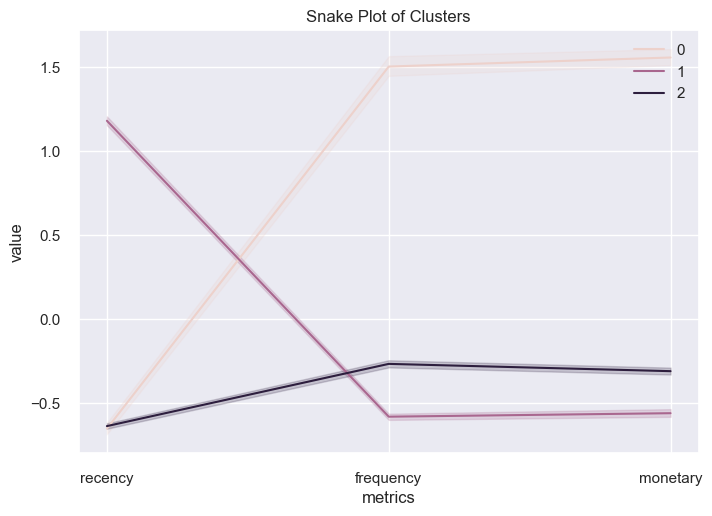

In [46]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)
plt.title('Snake Plot of Clusters')
plt.legend(loc = 'upper right')